# Задание 1.2 - Линейный классификатор (Linear classifier)

В этом задании мы реализуем другую модель машинного обучения - линейный классификатор. Линейный классификатор подбирает для каждого класса веса, на которые нужно умножить значение каждого признака и потом сложить вместе.
Тот класс, у которого эта сумма больше, и является предсказанием модели.

В этом задании вы:
- потренируетесь считать градиенты различных многомерных функций
- реализуете подсчет градиентов через линейную модель и функцию потерь softmax
- реализуете процесс тренировки линейного классификатора
- подберете параметры тренировки на практике

На всякий случай, еще раз ссылка на туториал по numpy:  
http://cs231n.github.io/python-numpy-tutorial/

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
from dataset import load_svhn, random_split_train_val
from gradient_check import check_gradient
from metrics import multiclass_accuracy 
import linear_classifer

# Как всегда, первым делом загружаем данные

Мы будем использовать все тот же SVHN.

In [3]:
def prepare_for_linear_classifier(train_X, test_X):
    train_flat = train_X.reshape(train_X.shape[0], -1).astype(np.float) / 255.0
    test_flat = test_X.reshape(test_X.shape[0], -1).astype(np.float) / 255.0
    
    # Subtract mean
    mean_image = np.mean(train_flat, axis = 0)
    train_flat -= mean_image
    test_flat -= mean_image
    
    # Add another channel with ones as a bias term
    train_flat_with_ones = np.hstack([train_flat, np.ones((train_X.shape[0], 1))])
    test_flat_with_ones = np.hstack([test_flat, np.ones((test_X.shape[0], 1))])    
    return train_flat_with_ones, test_flat_with_ones
    
train_X, train_y, test_X, test_y = load_svhn("data", max_train=10000, max_test=1000)    
train_X, test_X = prepare_for_linear_classifier(train_X, test_X)
# Split train into train and val
train_X, train_y, val_X, val_y = random_split_train_val(train_X, train_y, num_val = 1000)

# Играемся с градиентами!

В этом курсе мы будем писать много функций, которые вычисляют градиенты аналитическим методом.

Необходимым инструментом во время реализации кода, вычисляющего градиенты, является функция его проверки. Эта функция вычисляет градиент численным методом и сверяет результат с градиентом, вычисленным аналитическим методом.

Мы начнем с того, чтобы реализовать вычисление численного градиента (numeric gradient) в этой функции.
Вычислите градиент с помощью численной производной для каждой координаты. Для вычисления производной используйте так называемую two-point formula (https://en.wikipedia.org/wiki/Numerical_differentiation):

![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/22fc2c0a66c63560a349604f8b6b39221566236d)


In [4]:
# TODO: Implement gradient check function
def sqr(x):
    return x*x, 2*x

check_gradient(sqr, np.array([3.0]))

def array_sum(x):
    assert x.shape == (2,), x.shape
    return np.sum(x), np.ones_like(x)

check_gradient(array_sum, np.array([3.0, 2.0]))

def array_2d_sum(x):
    assert x.shape == (2,2)
    return np.sum(x), np.ones_like(x)

check_gradient(array_2d_sum, np.array([[3.0, 2.0], [1.0, 0.0]]))

Gradient check passed!
Gradient check passed!
Gradient check passed!


True

Теперь реализуем функцию softmax, которая получает на вход оценки для каждого класса и преобразует их в вероятности от 0 до 1:
![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/e348290cf48ddbb6e9a6ef4e39363568b67c09d3)

**Важно:** Практический аспект вычисления этой функции заключается в том, что в ней учавствует вычисление экспоненты от потенциально очень больших чисел - это может привести к очень большим значениям в числителе и знаменателе за пределами диапазона float.

К счастью, у этой проблемы есть простое решение -- перед вычислением softmax вычесть из всех оценок максимальное значение среди всех оценок:
```
predictions -= np.max(predictions)
```
(подробнее здесь - http://cs231n.github.io/linear-classify/#softmax, секция `Practical issues: Numeric stability`)

In [5]:
# TODO Implement softmax and cross-entropy for single sample
probs = linear_classifer.softmax(np.array([-10, 0, 10]))

# Make sure it works for big numbers too!
probs = linear_classifer.softmax(np.array([1000, 0, 0]))
assert np.isclose(probs[0], 1.0)

Кроме этого, мы реализуем cross-entropy loss, которую мы будем использовать как функцию ошибки (error function).
В общем виде cross-entropy определена следующим образом:
![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/0cb6da032ab424eefdca0884cd4113fe578f4293)

где x - все классы, p(x) - истинная вероятность принадлежности сэмпла классу x, а q(x) - вероятность принадлежности классу x, предсказанная моделью.  
В нашем случае сэмпл принадлежит только одному классу, индекс которого передается функции. Для него p(x) равна 1, а для остальных классов - 0. 

Это позволяет реализовать функцию проще!

In [6]:
probs = linear_classifer.softmax(np.array([-5, 0, 5]))
linear_classifer.cross_entropy_loss(probs, 1)

5.006760443547122

После того как мы реализовали сами функции, мы можем реализовать градиент.

Оказывается, что вычисление градиента становится гораздо проще, если объединить эти функции в одну, которая сначала вычисляет вероятности через softmax, а потом использует их для вычисления функции ошибки через cross-entropy loss.

Эта функция `softmax_with_cross_entropy` будет возвращает и значение ошибки, и градиент по входным параметрам. Мы проверим корректность реализации с помощью `check_gradient`.

In [7]:
# TODO Implement combined function or softmax and cross entropy and produces gradient
loss, grad = linear_classifer.softmax_with_cross_entropy(np.array([1, 0, 0]), 1)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, 1), np.array([1, 0, 0], np.float))

Gradient check passed!


True

В качестве метода тренировки мы будем использовать стохастический градиентный спуск (stochastic gradient descent или SGD), который работает с батчами сэмплов. 

Поэтому все наши фукнции будут получать не один пример, а батч, то есть входом будет не вектор из `num_classes` оценок, а матрица размерности `batch_size, num_classes`. Индекс примера в батче всегда будет первым измерением.

Следующий шаг - переписать наши функции так, чтобы они поддерживали батчи.

Финальное значение функции ошибки должно остаться числом, и оно равно среднему значению ошибки среди всех примеров в батче.

In [24]:
# TODO Extend combined function so it can receive a 2d array with batch of samples
np.random.seed(42)
# Test batch_size = 1
num_classes = 4
batch_size = 1
predictions = np.random.randint(-1, 3, size=(batch_size, num_classes)).astype(np.float)
target_index = np.random.randint(0, num_classes, size=(batch_size, 1)).astype(np.int)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, target_index), predictions)

# Test batch_size = 3
num_classes = 4
batch_size = 3
predictions = np.random.randint(-1, 3, size=(batch_size, num_classes)).astype(np.float)
target_index = np.random.randint(0, num_classes, size=(batch_size, 1)).astype(np.int)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, target_index), predictions)

Gradient check passed!
Gradient check passed!


True

### Наконец, реализуем сам линейный классификатор!

softmax и cross-entropy получают на вход оценки, которые выдает линейный классификатор.

Он делает это очень просто: для каждого класса есть набор весов, на которые надо умножить пиксели картинки и сложить. Получившееся число и является оценкой класса, идущей на вход softmax.

Таким образом, линейный классификатор можно представить как умножение вектора с пикселями на матрицу W размера `num_features, num_classes`. Такой подход легко расширяется на случай батча векторов с пикселями X размера `batch_size, num_features`:

`predictions = X * W`, где `*` - матричное умножение.

Реализуйте функцию подсчета линейного классификатора и градиентов по весам `linear_softmax` в файле `linear_classifer.py`

In [25]:
# TODO Implement linear_softmax function that uses softmax with cross-entropy for linear classifier
batch_size = 2
num_classes = 2
num_features = 3
np.random.seed(42)
W = np.random.randint(-1, 3, size=(num_features, num_classes)).astype(np.float)
X = np.random.randint(-1, 3, size=(batch_size, num_features)).astype(np.float)
target_index = np.ones(batch_size, dtype=np.int)

loss, dW = linear_classifer.linear_softmax(X, W, target_index)
check_gradient(lambda w: linear_classifer.linear_softmax(X, w, target_index), W)

Gradient check passed!


True

### И теперь регуляризация

Мы будем использовать L2 regularization для весов как часть общей функции ошибки.

Напомним, L2 regularization определяется как

l2_reg_loss = regularization_strength * sum<sub>ij</sub> W[i, j]<sup>2</sup>

Реализуйте функцию для его вычисления и вычисления соотвествующих градиентов.

In [26]:
# TODO Implement l2_regularization function that implements loss for L2 regularization
linear_classifer.l2_regularization(W, 0.01)
check_gradient(lambda w: linear_classifer.l2_regularization(w, 0.01), W)

Gradient check passed!


True

# Тренировка!

Градиенты в порядке, реализуем процесс тренировки!

In [31]:
# TODO: Implement LinearSoftmaxClassifier.fit function
classifier = linear_classifer.LinearSoftmaxClassifier()
loss_history = classifier.fit(train_X, train_y, epochs=10, learning_rate=1e-3, batch_size=300, reg=1e1)

Epoch 0, loss: 2.396122
Epoch 1, loss: 2.330286
Epoch 2, loss: 2.311307
Epoch 3, loss: 2.304966
Epoch 4, loss: 2.302548
Epoch 5, loss: 2.302356
Epoch 6, loss: 2.301226
Epoch 7, loss: 2.302575
Epoch 8, loss: 2.301648
Epoch 9, loss: 2.300996


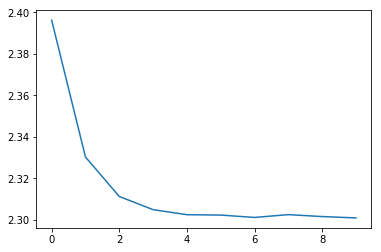

In [32]:
# let's look at the loss history!
plt.plot(loss_history)

In [33]:
# Let's check how it performs on validation set
pred = classifier.predict(val_X)
accuracy = multiclass_accuracy(pred, val_y)
print("Accuracy: ", accuracy)

# Now, let's train more and see if it performs better
classifier.fit(train_X, train_y, epochs=100, learning_rate=1e-3, batch_size=300, reg=1e1)
pred = classifier.predict(val_X)
accuracy = multiclass_accuracy(pred, val_y)
print("Accuracy after training for 100 epochs: ", accuracy)

Accuracy:  0.122
Epoch 0, loss: 2.301319
Epoch 1, loss: 2.301630
Epoch 2, loss: 2.302040
Epoch 3, loss: 2.302776
Epoch 4, loss: 2.301997
Epoch 5, loss: 2.301170
Epoch 6, loss: 2.301850
Epoch 7, loss: 2.301307
Epoch 8, loss: 2.302009
Epoch 9, loss: 2.301612
Epoch 10, loss: 2.301402
Epoch 11, loss: 2.301722
Epoch 12, loss: 2.302269
Epoch 13, loss: 2.302016
Epoch 14, loss: 2.301948
Epoch 15, loss: 2.302136
Epoch 16, loss: 2.301457
Epoch 17, loss: 2.301395
Epoch 18, loss: 2.302324
Epoch 19, loss: 2.302314
Epoch 20, loss: 2.301831
Epoch 21, loss: 2.302010
Epoch 22, loss: 2.301606
Epoch 23, loss: 2.301418
Epoch 24, loss: 2.301640
Epoch 25, loss: 2.302292
Epoch 26, loss: 2.300953
Epoch 27, loss: 2.302985
Epoch 28, loss: 2.301831
Epoch 29, loss: 2.301836
Epoch 30, loss: 2.302415
Epoch 31, loss: 2.301963
Epoch 32, loss: 2.301878
Epoch 33, loss: 2.302989
Epoch 34, loss: 2.301542
Epoch 35, loss: 2.302269
Epoch 36, loss: 2.301220
Epoch 37, loss: 2.301678
Epoch 38, loss: 2.303474
Epoch 39, loss: 2.

### Как и раньше, используем кросс-валидацию для подбора гиперпараметтов.

В этот раз, чтобы тренировка занимала разумное время, мы будем использовать только одно разделение на тренировочные (training) и проверочные (validation) данные.

Теперь нам нужно подобрать не один, а два гиперпараметра! Не ограничивайте себя изначальными значениями в коде.  
Добейтесь точности более чем **20%** на проверочных данных (validation data).

In [34]:
num_epochs = 200
batch_size = 300

learning_rates = [1e-2, 1e-3, 1e-4, 1e-5, 1e-6]
reg_strengths = [1e-2, 1e-3, 1e-4, 1e-5, 1e-6]

best_classifier = None
best_val_accuracy = 0
best_learning_rate = None
best_regular_strength = None

# TODO use validation set to find the best hyperparameters
# hint: for best results, you might need to try more values for learning rate and regularization strength 
# than provided initially

for lr in learning_rates:
    for rs in reg_strengths:
        classifier = linear_classifer.LinearSoftmaxClassifier()
        classifier.fit(train_X, train_y, epochs=num_epochs, learning_rate=lr, batch_size=batch_size, reg=rs)
        pred = classifier.predict(val_X)
        accuracy = multiclass_accuracy(pred, val_y)
        if accuracy > best_val_accuracy:
            best_val_accuracy = accuracy
            best_classifier = classifier
            best_learning_rate = lr
            best_regular_strength = rs
print('best validation accuracy achieved: %f' % best_val_accuracy)

Epoch 0, loss: 2.296753
Epoch 1, loss: 2.287977
Epoch 2, loss: 2.281562
Epoch 3, loss: 2.267232
Epoch 4, loss: 2.273062
Epoch 5, loss: 2.259402
Epoch 6, loss: 2.246823
Epoch 7, loss: 2.263407
Epoch 8, loss: 2.247202
Epoch 9, loss: 2.249877
Epoch 10, loss: 2.232420
Epoch 11, loss: 2.230258
Epoch 12, loss: 2.228682
Epoch 13, loss: 2.224422
Epoch 14, loss: 2.211166
Epoch 15, loss: 2.222906
Epoch 16, loss: 2.223859
Epoch 17, loss: 2.234504
Epoch 18, loss: 2.239521
Epoch 19, loss: 2.204405
Epoch 20, loss: 2.228733
Epoch 21, loss: 2.220195
Epoch 22, loss: 2.214101
Epoch 23, loss: 2.206765
Epoch 24, loss: 2.225676
Epoch 25, loss: 2.194413
Epoch 26, loss: 2.226312
Epoch 27, loss: 2.186540
Epoch 28, loss: 2.231240
Epoch 29, loss: 2.211193
Epoch 30, loss: 2.212680
Epoch 31, loss: 2.181727
Epoch 32, loss: 2.185922
Epoch 33, loss: 2.222461
Epoch 34, loss: 2.201998
Epoch 35, loss: 2.198388
Epoch 36, loss: 2.184628
Epoch 37, loss: 2.196082
Epoch 38, loss: 2.191754
Epoch 39, loss: 2.196911
Epoch 40, 

Epoch 124, loss: 2.114373
Epoch 125, loss: 2.112362
Epoch 126, loss: 2.112902
Epoch 127, loss: 2.050429
Epoch 128, loss: 2.105525
Epoch 129, loss: 2.074936
Epoch 130, loss: 2.144457
Epoch 131, loss: 2.145868
Epoch 132, loss: 2.094927
Epoch 133, loss: 2.170504
Epoch 134, loss: 2.106004
Epoch 135, loss: 2.155834
Epoch 136, loss: 2.064332
Epoch 137, loss: 2.138407
Epoch 138, loss: 2.086744
Epoch 139, loss: 2.109103
Epoch 140, loss: 2.136193
Epoch 141, loss: 2.117638
Epoch 142, loss: 2.082770
Epoch 143, loss: 2.129806
Epoch 144, loss: 2.143892
Epoch 145, loss: 2.084755
Epoch 146, loss: 2.146203
Epoch 147, loss: 2.070062
Epoch 148, loss: 2.114873
Epoch 149, loss: 2.097823
Epoch 150, loss: 2.149682
Epoch 151, loss: 2.095726
Epoch 152, loss: 2.097533
Epoch 153, loss: 2.106977
Epoch 154, loss: 2.101544
Epoch 155, loss: 2.131032
Epoch 156, loss: 2.135274
Epoch 157, loss: 2.163696
Epoch 158, loss: 2.143386
Epoch 159, loss: 2.077999
Epoch 160, loss: 2.103293
Epoch 161, loss: 2.102239
Epoch 162, l

Epoch 46, loss: 2.179019
Epoch 47, loss: 2.137932
Epoch 48, loss: 2.141900
Epoch 49, loss: 2.088552
Epoch 50, loss: 2.148601
Epoch 51, loss: 2.112302
Epoch 52, loss: 2.169082
Epoch 53, loss: 2.145271
Epoch 54, loss: 2.175329
Epoch 55, loss: 2.129617
Epoch 56, loss: 2.176921
Epoch 57, loss: 2.159463
Epoch 58, loss: 2.120488
Epoch 59, loss: 2.136158
Epoch 60, loss: 2.117205
Epoch 61, loss: 2.129273
Epoch 62, loss: 2.134906
Epoch 63, loss: 2.178419
Epoch 64, loss: 2.124549
Epoch 65, loss: 2.152221
Epoch 66, loss: 2.111453
Epoch 67, loss: 2.112817
Epoch 68, loss: 2.190858
Epoch 69, loss: 2.112519
Epoch 70, loss: 2.127963
Epoch 71, loss: 2.125531
Epoch 72, loss: 2.156257
Epoch 73, loss: 2.136336
Epoch 74, loss: 2.186565
Epoch 75, loss: 2.147203
Epoch 76, loss: 2.134752
Epoch 77, loss: 2.147331
Epoch 78, loss: 2.118584
Epoch 79, loss: 2.144391
Epoch 80, loss: 2.178716
Epoch 81, loss: 2.099806
Epoch 82, loss: 2.138832
Epoch 83, loss: 2.113766
Epoch 84, loss: 2.111738
Epoch 85, loss: 2.077999


Epoch 168, loss: 2.126634
Epoch 169, loss: 2.163405
Epoch 170, loss: 2.168226
Epoch 171, loss: 2.119791
Epoch 172, loss: 2.125830
Epoch 173, loss: 2.064460
Epoch 174, loss: 2.088318
Epoch 175, loss: 2.152356
Epoch 176, loss: 2.094641
Epoch 177, loss: 2.088128
Epoch 178, loss: 2.099339
Epoch 179, loss: 2.061699
Epoch 180, loss: 2.112702
Epoch 181, loss: 2.036855
Epoch 182, loss: 2.157252
Epoch 183, loss: 2.149150
Epoch 184, loss: 2.118402
Epoch 185, loss: 2.058118
Epoch 186, loss: 2.117788
Epoch 187, loss: 2.112758
Epoch 188, loss: 2.083670
Epoch 189, loss: 2.126480
Epoch 190, loss: 2.083441
Epoch 191, loss: 2.094032
Epoch 192, loss: 2.081083
Epoch 193, loss: 2.083845
Epoch 194, loss: 2.078987
Epoch 195, loss: 2.097560
Epoch 196, loss: 2.177981
Epoch 197, loss: 2.081003
Epoch 198, loss: 2.090156
Epoch 199, loss: 2.130063
Epoch 0, loss: 2.302439
Epoch 1, loss: 2.300913
Epoch 2, loss: 2.301915
Epoch 3, loss: 2.301094
Epoch 4, loss: 2.297294
Epoch 5, loss: 2.296863
Epoch 6, loss: 2.296053


Epoch 92, loss: 2.237521
Epoch 93, loss: 2.232580
Epoch 94, loss: 2.237227
Epoch 95, loss: 2.262531
Epoch 96, loss: 2.243895
Epoch 97, loss: 2.245191
Epoch 98, loss: 2.248949
Epoch 99, loss: 2.231953
Epoch 100, loss: 2.239892
Epoch 101, loss: 2.236110
Epoch 102, loss: 2.241229
Epoch 103, loss: 2.257555
Epoch 104, loss: 2.246529
Epoch 105, loss: 2.246716
Epoch 106, loss: 2.230460
Epoch 107, loss: 2.232104
Epoch 108, loss: 2.235404
Epoch 109, loss: 2.247115
Epoch 110, loss: 2.228638
Epoch 111, loss: 2.231561
Epoch 112, loss: 2.222556
Epoch 113, loss: 2.229704
Epoch 114, loss: 2.236848
Epoch 115, loss: 2.221291
Epoch 116, loss: 2.255662
Epoch 117, loss: 2.244310
Epoch 118, loss: 2.226340
Epoch 119, loss: 2.228091
Epoch 120, loss: 2.216882
Epoch 121, loss: 2.222684
Epoch 122, loss: 2.218675
Epoch 123, loss: 2.252341
Epoch 124, loss: 2.209948
Epoch 125, loss: 2.219492
Epoch 126, loss: 2.220645
Epoch 127, loss: 2.233356
Epoch 128, loss: 2.231733
Epoch 129, loss: 2.227997
Epoch 130, loss: 2.2

Epoch 13, loss: 2.292363
Epoch 14, loss: 2.285796
Epoch 15, loss: 2.291445
Epoch 16, loss: 2.286128
Epoch 17, loss: 2.292921
Epoch 18, loss: 2.284627
Epoch 19, loss: 2.279595
Epoch 20, loss: 2.289134
Epoch 21, loss: 2.285454
Epoch 22, loss: 2.286898
Epoch 23, loss: 2.282291
Epoch 24, loss: 2.281733
Epoch 25, loss: 2.281657
Epoch 26, loss: 2.276433
Epoch 27, loss: 2.281070
Epoch 28, loss: 2.276564
Epoch 29, loss: 2.278075
Epoch 30, loss: 2.278618
Epoch 31, loss: 2.282547
Epoch 32, loss: 2.279613
Epoch 33, loss: 2.277365
Epoch 34, loss: 2.266365
Epoch 35, loss: 2.278252
Epoch 36, loss: 2.267351
Epoch 37, loss: 2.268015
Epoch 38, loss: 2.277860
Epoch 39, loss: 2.277481
Epoch 40, loss: 2.273087
Epoch 41, loss: 2.271342
Epoch 42, loss: 2.263760
Epoch 43, loss: 2.282058
Epoch 44, loss: 2.266708
Epoch 45, loss: 2.274547
Epoch 46, loss: 2.262015
Epoch 47, loss: 2.262469
Epoch 48, loss: 2.265853
Epoch 49, loss: 2.259293
Epoch 50, loss: 2.262100
Epoch 51, loss: 2.269689
Epoch 52, loss: 2.252343


Epoch 136, loss: 2.228683
Epoch 137, loss: 2.239637
Epoch 138, loss: 2.238322
Epoch 139, loss: 2.228515
Epoch 140, loss: 2.240554
Epoch 141, loss: 2.224311
Epoch 142, loss: 2.190080
Epoch 143, loss: 2.237117
Epoch 144, loss: 2.202813
Epoch 145, loss: 2.217294
Epoch 146, loss: 2.218535
Epoch 147, loss: 2.199354
Epoch 148, loss: 2.216826
Epoch 149, loss: 2.216214
Epoch 150, loss: 2.195283
Epoch 151, loss: 2.216232
Epoch 152, loss: 2.212390
Epoch 153, loss: 2.217899
Epoch 154, loss: 2.198966
Epoch 155, loss: 2.209865
Epoch 156, loss: 2.219616
Epoch 157, loss: 2.193063
Epoch 158, loss: 2.219787
Epoch 159, loss: 2.202297
Epoch 160, loss: 2.234216
Epoch 161, loss: 2.216043
Epoch 162, loss: 2.205527
Epoch 163, loss: 2.219948
Epoch 164, loss: 2.200613
Epoch 165, loss: 2.242842
Epoch 166, loss: 2.199044
Epoch 167, loss: 2.176353
Epoch 168, loss: 2.213741
Epoch 169, loss: 2.174110
Epoch 170, loss: 2.229156
Epoch 171, loss: 2.201981
Epoch 172, loss: 2.209971
Epoch 173, loss: 2.208587
Epoch 174, l

Epoch 58, loss: 2.298818
Epoch 59, loss: 2.295685
Epoch 60, loss: 2.298243
Epoch 61, loss: 2.299103
Epoch 62, loss: 2.295085
Epoch 63, loss: 2.296654
Epoch 64, loss: 2.298651
Epoch 65, loss: 2.297214
Epoch 66, loss: 2.299064
Epoch 67, loss: 2.296988
Epoch 68, loss: 2.296935
Epoch 69, loss: 2.296249
Epoch 70, loss: 2.294052
Epoch 71, loss: 2.291471
Epoch 72, loss: 2.297081
Epoch 73, loss: 2.295329
Epoch 74, loss: 2.294834
Epoch 75, loss: 2.296697
Epoch 76, loss: 2.296612
Epoch 77, loss: 2.296250
Epoch 78, loss: 2.292920
Epoch 79, loss: 2.296219
Epoch 80, loss: 2.295230
Epoch 81, loss: 2.298752
Epoch 82, loss: 2.296125
Epoch 83, loss: 2.295644
Epoch 84, loss: 2.296411
Epoch 85, loss: 2.294562
Epoch 86, loss: 2.293971
Epoch 87, loss: 2.295980
Epoch 88, loss: 2.293728
Epoch 89, loss: 2.291869
Epoch 90, loss: 2.294779
Epoch 91, loss: 2.296595
Epoch 92, loss: 2.291843
Epoch 93, loss: 2.293565
Epoch 94, loss: 2.295590
Epoch 95, loss: 2.294501
Epoch 96, loss: 2.293716
Epoch 97, loss: 2.293083


Epoch 179, loss: 2.283650
Epoch 180, loss: 2.289474
Epoch 181, loss: 2.286361
Epoch 182, loss: 2.282627
Epoch 183, loss: 2.287612
Epoch 184, loss: 2.286578
Epoch 185, loss: 2.287120
Epoch 186, loss: 2.281442
Epoch 187, loss: 2.289455
Epoch 188, loss: 2.283017
Epoch 189, loss: 2.286096
Epoch 190, loss: 2.286656
Epoch 191, loss: 2.287253
Epoch 192, loss: 2.291392
Epoch 193, loss: 2.286255
Epoch 194, loss: 2.287500
Epoch 195, loss: 2.283635
Epoch 196, loss: 2.283583
Epoch 197, loss: 2.280464
Epoch 198, loss: 2.288212
Epoch 199, loss: 2.286982
Epoch 0, loss: 2.303126
Epoch 1, loss: 2.302940
Epoch 2, loss: 2.303224
Epoch 3, loss: 2.302696
Epoch 4, loss: 2.303401
Epoch 5, loss: 2.302961
Epoch 6, loss: 2.302277
Epoch 7, loss: 2.302812
Epoch 8, loss: 2.302054
Epoch 9, loss: 2.301897
Epoch 10, loss: 2.302013
Epoch 11, loss: 2.302864
Epoch 12, loss: 2.301282
Epoch 13, loss: 2.301442
Epoch 14, loss: 2.299917
Epoch 15, loss: 2.301377
Epoch 16, loss: 2.301976
Epoch 17, loss: 2.301529
Epoch 18, loss

Epoch 103, loss: 2.291440
Epoch 104, loss: 2.290728
Epoch 105, loss: 2.294564
Epoch 106, loss: 2.293927
Epoch 107, loss: 2.290797
Epoch 108, loss: 2.290275
Epoch 109, loss: 2.292577
Epoch 110, loss: 2.290925
Epoch 111, loss: 2.293542
Epoch 112, loss: 2.291041
Epoch 113, loss: 2.295515
Epoch 114, loss: 2.288124
Epoch 115, loss: 2.292774
Epoch 116, loss: 2.293252
Epoch 117, loss: 2.292549
Epoch 118, loss: 2.293509
Epoch 119, loss: 2.291639
Epoch 120, loss: 2.291917
Epoch 121, loss: 2.289995
Epoch 122, loss: 2.290981
Epoch 123, loss: 2.292994
Epoch 124, loss: 2.294455
Epoch 125, loss: 2.288629
Epoch 126, loss: 2.296425
Epoch 127, loss: 2.294971
Epoch 128, loss: 2.290461
Epoch 129, loss: 2.291918
Epoch 130, loss: 2.291327
Epoch 131, loss: 2.290612
Epoch 132, loss: 2.290913
Epoch 133, loss: 2.290293
Epoch 134, loss: 2.287245
Epoch 135, loss: 2.288581
Epoch 136, loss: 2.288466
Epoch 137, loss: 2.289538
Epoch 138, loss: 2.286793
Epoch 139, loss: 2.288668
Epoch 140, loss: 2.284242
Epoch 141, l

Epoch 24, loss: 2.303742
Epoch 25, loss: 2.302931
Epoch 26, loss: 2.302624
Epoch 27, loss: 2.302413
Epoch 28, loss: 2.303404
Epoch 29, loss: 2.303632
Epoch 30, loss: 2.303098
Epoch 31, loss: 2.301525
Epoch 32, loss: 2.302140
Epoch 33, loss: 2.302675
Epoch 34, loss: 2.301732
Epoch 35, loss: 2.303255
Epoch 36, loss: 2.302013
Epoch 37, loss: 2.300685
Epoch 38, loss: 2.301975
Epoch 39, loss: 2.303012
Epoch 40, loss: 2.301334
Epoch 41, loss: 2.302557
Epoch 42, loss: 2.302890
Epoch 43, loss: 2.300950
Epoch 44, loss: 2.302068
Epoch 45, loss: 2.301546
Epoch 46, loss: 2.303168
Epoch 47, loss: 2.302632
Epoch 48, loss: 2.304224
Epoch 49, loss: 2.303016
Epoch 50, loss: 2.301827
Epoch 51, loss: 2.302715
Epoch 52, loss: 2.304087
Epoch 53, loss: 2.303383
Epoch 54, loss: 2.301204
Epoch 55, loss: 2.301359
Epoch 56, loss: 2.301065
Epoch 57, loss: 2.302016
Epoch 58, loss: 2.302346
Epoch 59, loss: 2.302503
Epoch 60, loss: 2.301252
Epoch 61, loss: 2.302784
Epoch 62, loss: 2.302727
Epoch 63, loss: 2.302827


Epoch 147, loss: 2.301575
Epoch 148, loss: 2.299877
Epoch 149, loss: 2.301511
Epoch 150, loss: 2.300489
Epoch 151, loss: 2.301667
Epoch 152, loss: 2.300334
Epoch 153, loss: 2.300460
Epoch 154, loss: 2.300087
Epoch 155, loss: 2.301006
Epoch 156, loss: 2.300301
Epoch 157, loss: 2.301067
Epoch 158, loss: 2.300212
Epoch 159, loss: 2.300025
Epoch 160, loss: 2.301986
Epoch 161, loss: 2.302415
Epoch 162, loss: 2.300262
Epoch 163, loss: 2.300454
Epoch 164, loss: 2.299902
Epoch 165, loss: 2.301106
Epoch 166, loss: 2.300384
Epoch 167, loss: 2.300571
Epoch 168, loss: 2.300069
Epoch 169, loss: 2.301121
Epoch 170, loss: 2.301355
Epoch 171, loss: 2.301175
Epoch 172, loss: 2.300087
Epoch 173, loss: 2.300435
Epoch 174, loss: 2.300635
Epoch 175, loss: 2.300831
Epoch 176, loss: 2.300715
Epoch 177, loss: 2.301409
Epoch 178, loss: 2.300143
Epoch 179, loss: 2.300677
Epoch 180, loss: 2.300850
Epoch 181, loss: 2.301168
Epoch 182, loss: 2.300198
Epoch 183, loss: 2.300887
Epoch 184, loss: 2.302208
Epoch 185, l

Epoch 70, loss: 2.302201
Epoch 71, loss: 2.301973
Epoch 72, loss: 2.303301
Epoch 73, loss: 2.300639
Epoch 74, loss: 2.301705
Epoch 75, loss: 2.301957
Epoch 76, loss: 2.301362
Epoch 77, loss: 2.301137
Epoch 78, loss: 2.301255
Epoch 79, loss: 2.301280
Epoch 80, loss: 2.302211
Epoch 81, loss: 2.300626
Epoch 82, loss: 2.300531
Epoch 83, loss: 2.301525
Epoch 84, loss: 2.301375
Epoch 85, loss: 2.302800
Epoch 86, loss: 2.302241
Epoch 87, loss: 2.300761
Epoch 88, loss: 2.300478
Epoch 89, loss: 2.301754
Epoch 90, loss: 2.301059
Epoch 91, loss: 2.300556
Epoch 92, loss: 2.301668
Epoch 93, loss: 2.301936
Epoch 94, loss: 2.301250
Epoch 95, loss: 2.302163
Epoch 96, loss: 2.300669
Epoch 97, loss: 2.301298
Epoch 98, loss: 2.301148
Epoch 99, loss: 2.300126
Epoch 100, loss: 2.300787
Epoch 101, loss: 2.300592
Epoch 102, loss: 2.301074
Epoch 103, loss: 2.300543
Epoch 104, loss: 2.301358
Epoch 105, loss: 2.300810
Epoch 106, loss: 2.301199
Epoch 107, loss: 2.300711
Epoch 108, loss: 2.301173
Epoch 109, loss:

Epoch 191, loss: 2.302149
Epoch 192, loss: 2.302601
Epoch 193, loss: 2.303492
Epoch 194, loss: 2.302612
Epoch 195, loss: 2.301901
Epoch 196, loss: 2.302399
Epoch 197, loss: 2.301996
Epoch 198, loss: 2.301766
Epoch 199, loss: 2.301845
Epoch 0, loss: 2.303923
Epoch 1, loss: 2.302717
Epoch 2, loss: 2.302674
Epoch 3, loss: 2.302015
Epoch 4, loss: 2.302799
Epoch 5, loss: 2.302579
Epoch 6, loss: 2.302266
Epoch 7, loss: 2.302745
Epoch 8, loss: 2.303001
Epoch 9, loss: 2.301740
Epoch 10, loss: 2.302670
Epoch 11, loss: 2.303019
Epoch 12, loss: 2.303020
Epoch 13, loss: 2.301834
Epoch 14, loss: 2.301857
Epoch 15, loss: 2.303094
Epoch 16, loss: 2.301583
Epoch 17, loss: 2.302329
Epoch 18, loss: 2.302186
Epoch 19, loss: 2.302125
Epoch 20, loss: 2.302723
Epoch 21, loss: 2.302107
Epoch 22, loss: 2.301317
Epoch 23, loss: 2.303022
Epoch 24, loss: 2.301551
Epoch 25, loss: 2.302615
Epoch 26, loss: 2.302604
Epoch 27, loss: 2.302097
Epoch 28, loss: 2.303367
Epoch 29, loss: 2.303320
Epoch 30, loss: 2.301712
E

Epoch 115, loss: 2.302588
Epoch 116, loss: 2.300896
Epoch 117, loss: 2.301988
Epoch 118, loss: 2.303003
Epoch 119, loss: 2.303145
Epoch 120, loss: 2.302229
Epoch 121, loss: 2.301752
Epoch 122, loss: 2.302825
Epoch 123, loss: 2.302101
Epoch 124, loss: 2.301819
Epoch 125, loss: 2.303056
Epoch 126, loss: 2.302239
Epoch 127, loss: 2.303532
Epoch 128, loss: 2.302054
Epoch 129, loss: 2.302247
Epoch 130, loss: 2.302943
Epoch 131, loss: 2.302381
Epoch 132, loss: 2.302614
Epoch 133, loss: 2.302114
Epoch 134, loss: 2.302426
Epoch 135, loss: 2.302188
Epoch 136, loss: 2.301767
Epoch 137, loss: 2.302010
Epoch 138, loss: 2.302127
Epoch 139, loss: 2.302430
Epoch 140, loss: 2.302017
Epoch 141, loss: 2.303395
Epoch 142, loss: 2.302361
Epoch 143, loss: 2.302835
Epoch 144, loss: 2.302422
Epoch 145, loss: 2.301879
Epoch 146, loss: 2.302550
Epoch 147, loss: 2.302373
Epoch 148, loss: 2.302393
Epoch 149, loss: 2.303450
Epoch 150, loss: 2.302799
Epoch 151, loss: 2.302481
Epoch 152, loss: 2.302271
Epoch 153, l

Epoch 37, loss: 2.303227
Epoch 38, loss: 2.301307
Epoch 39, loss: 2.302750
Epoch 40, loss: 2.303723
Epoch 41, loss: 2.303457
Epoch 42, loss: 2.302678
Epoch 43, loss: 2.301735
Epoch 44, loss: 2.302433
Epoch 45, loss: 2.301675
Epoch 46, loss: 2.303245
Epoch 47, loss: 2.302604
Epoch 48, loss: 2.303075
Epoch 49, loss: 2.302810
Epoch 50, loss: 2.303274
Epoch 51, loss: 2.303087
Epoch 52, loss: 2.302748
Epoch 53, loss: 2.302922
Epoch 54, loss: 2.303041
Epoch 55, loss: 2.302583
Epoch 56, loss: 2.303493
Epoch 57, loss: 2.302972
Epoch 58, loss: 2.303234
Epoch 59, loss: 2.302195
Epoch 60, loss: 2.302603
Epoch 61, loss: 2.302460
Epoch 62, loss: 2.303480
Epoch 63, loss: 2.302959
Epoch 64, loss: 2.303515
Epoch 65, loss: 2.303488
Epoch 66, loss: 2.302585
Epoch 67, loss: 2.303089
Epoch 68, loss: 2.302760
Epoch 69, loss: 2.303052
Epoch 70, loss: 2.302491
Epoch 71, loss: 2.304155
Epoch 72, loss: 2.302064
Epoch 73, loss: 2.301806
Epoch 74, loss: 2.303085
Epoch 75, loss: 2.303317
Epoch 76, loss: 2.302767


# Какой же точности мы добились на тестовых данных?

In [35]:
test_pred = best_classifier.predict(test_X)
test_accuracy = multiclass_accuracy(test_pred, test_y)
print('Linear softmax classifier test set accuracy: %f' % (test_accuracy, ))

Linear softmax classifier test set accuracy: 0.208000
